<div style="text-align: right"> Mark Hendricks </div>

<left>FINM 37400 - Fixed Income</left> 
<br>
<left>Winter 2024</left>

<h2><center> Homework #1- Data Exploration, Discount Curve, Nelson Siegel Curve </center></h2>

<center>Due: Wednesday, Jan 10 at 6PM</center>

<h3><span style="color:#00008B">Name - Nick Lewis</span></h3>
<h3><span style="color:#00008B">Email - nicklewis16@uchicago.edu</span></h3>

This homework relies on the data file, `treasury_quotes_2023-07-26`.

#### Nominal Securities
The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `ITYPE` of 11 or 12, as these indicate a TIPS Note or TIPS bond.


#### More Info
Find more info about many of the fields in the data set at the following link,

https://www.crsp.org/products/documentation/treasno-properties

Find the complete manual for the CRSP Treasury data at the following link,

https://www.crsp.org/files/treasury_guide_0.pdf

# IMPORTS AND HELPER FUNCTIONS

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import copy

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import fsolve
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15

In [2]:
def check_dates(df):
    t_check = df['CALDT'].values[0]
    if df['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None
    return t_current

def data_summary(rdata, t_current):
    res = rdata[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']].copy()
    #TDYLD: PROMISED YIELD DAILY RATE, ALSO CALLED DAILY YIELD TO MATURITY.
    #IF A PRICE IS MISSING, THE tdyld IS SET TO -99
    res.columns = ['issue date','maturity date','coupon rate','yld', 'duration','outstanding']
    res['yld'] *= 365
    #DURATION: THE DAILY SERIES OF THE WEIGHTED AVERAGE NUMBER OF DAYS UNTIL THE CASH FLOWS OCCUR, WHERE THE PRESENT VALUES, DISCOUNTED BY YIELD TO MATURITY, 
    #OF EACH PAYMENT ARE USED AS THE WEIGHTS.
    res['duration'] /= 365
    #outstanding: DAILY SERIES OF THE AMOUNT (FACE VALUE) HELD BY THE PUBLIC IN MILLIONS OF DOLLARS
    res['outstanding'] *= 1e6
    res['maturity'] = get_maturity_delta(res['maturity date'], t_current)
    #TDACCINT: DAILY SERIES OF TOTAL ACCRUED INTEREST
    res['price'] = (rdata['TDBID'] + rdata['TDASK'])/2 + rdata['TDACCINT']
    res['bid-ask'] = rdata['TDASK'] - rdata['TDBID']
    res['next cashflow'] = (calc_cashflow(rdata)!=0).idxmax(1)
    return res

def process_treasury_quotes(filepath):
    '''
    Provide quote date. Date is read into file assuming in same directory as this file.
    Data is processed raw prices (midpoint) are calculated.
    Rawdata and basic metrics are returned, make sure to have a tuple accept the function returns.
    '''
    #TDYLD: PROMISED YIELD DAILY RATE, ALSO CALLED DAILY YIELD TO MATURITY.
    #IF A PRICE IS MISSING, THE tdyld IS SET TO -99
    #DURATION: THE DAILY SERIES OF THE WEIGHTED AVERAGE NUMBER OF DAYS UNTIL THE CASH FLOWS OCCUR, WHERE THE PRESENT VALUES, DISCOUNTED BY YIELD TO MATURITY, 
    #OF EACH PAYMENT ARE USED AS THE WEIGHTS.
    #outstanding: DAILY SERIES OF THE AMOUNT (FACE VALUE) HELD BY THE PUBLIC IN MILLIONS OF DOLLARS
    #TDACCINT: DAILY SERIES OF TOTAL ACCRUED INTEREST
    # filepath_rawdata = f'treasury_quotes_{quote_date}.xlsx'
    rawdata = pd.read_excel(filepath,sheet_name='quotes')
    rawdata.columns = rawdata.columns.str.upper()
    rawdata.sort_values('TMATDT',inplace=True)
    rawdata.set_index('KYTREASNO',inplace=True)

    t_check = rawdata['CALDT'].values[0]
    if rawdata['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None

    rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
    rawprices.name = 'price'

    maturity_delta = get_maturity_delta(rawdata['TMATDT'],t_current)
    maturity_delta.name = 'maturity delta'

    metrics = rawdata.copy()[['TDATDT','TMATDT','TDPUBOUT','TCOUPRT','TDYLD','TDDURATN']]
    metrics.columns = ['issue date','maturity date','outstanding','coupon rate','yld','duration']
    metrics['yld'] *= 365
    metrics['duration'] /= 365
    metrics['outstanding'] *= 1e6
    metrics['maturity'] = get_maturity_delta(metrics['maturity date'], t_current)
    metrics['price'] = rawprices
    metrics['bid-ask'] = rawdata['TDASK'] - rawdata['TDBID']
    metrics['next cashflow'] = (calc_cashflow(rawdata)!=0).idxmax(1)
    return rawdata, metrics

def get_maturity_delta(t_maturity,t_current):
    '''
    The `get_maturity_delta` function calculates the difference in time between the `t_maturity` and `t_current` dates,
    and returns the result as a float representing the number of years.
    '''
    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')
    
    return maturity_delta

def parse_date(date):
    """Parses a string date into a datetime object. If input is not a string, returns it as is."""
    return datetime.datetime.strptime(date, '%Y-%m-%d') if isinstance(date, str) else date

def get_coupon_dates(quote_date, maturity_date):
    """Generates coupon dates between quote date and maturity date."""
    quote_date, maturity_date = map(parse_date, [quote_date, maturity_date])
    periods = np.ceil((maturity_date - quote_date).days / 180)
    temp =  pd.date_range(end=maturity_date, periods=periods, freq = pd.DateOffset(months=6))
    #return coupon dates after quotation date
    next_coupon_date = pd.DataFrame(temp[temp > quote_date])[0]

    return next_coupon_date

def calc_cashflow(rdata):
    """
    Create a cash flow table for bonds based on their coupon dates and rates.

    Parameters:
    rdata: DataFrame containing bond information with columns 'CALDT' (issue date),
           'TMATDT' (maturity date), and 'TCOUPRT' (annual coupon rate).

    Returns:
    cf_table: DataFrame representing the cash flow of each bond.
    """

    # Initialize a DataFrame to store cash flows, with rows as bonds and columns as unique maturity dates
    cf_table = pd.DataFrame(0, index=rdata.index, columns=pd.to_datetime(rdata['TMATDT'].unique()))

    # Iterate over each bond to calculate cash flows
    for bond in rdata.itertuples():
        # Calculate all future coupon dates
        coupon_dates = get_coupon_dates(bond.CALDT, bond.TMATDT)

        # Add coupon rate to those dates (TCOUPRT is annual coupon rate, so divide by two for semiannual)
        if coupon_dates is not None:
            cf_table.loc[bond.Index, coupon_dates] = bond.TCOUPRT / 2

        # Add face value at maturity
        cf_table.loc[bond.Index, bond.TMATDT] += 100

    # Fill any NaN values with 0 and sort the columns by date
    cf_table.fillna(0, inplace=True)
    cf_table.sort_index(axis=1, inplace=True)

    # Remove columns where all values are zero
    cf_table = cf_table.loc[:, (cf_table != 0).any()]

    return cf_table

def filter_treasuries(data, 
                      t_date=None, 
                      max_maturity_years=None, 
                      min_maturity_years=None, 
                      drop_duplicate_maturities=False, 
                      include_tips=False, 
                      exclude_zero_yield=True):
    """
    Filters a DataFrame of treasury data based on various criteria.

    Parameters:
    data: DataFrame containing treasury data.
    t_date: Date to filter the data on. Defaults to the latest 'CALDT' in the data.
    max_maturity_years: Maximum maturity in years to include. None means no maximum.
    min_maturity_years: Minimum maturity in years to include. None means no minimum.
    drop_duplicate_maturities: Boolean, if True, drops duplicate maturity dates.
    include_tips: Boolean, if False, excludes TIPS (Treasury Inflation Protected Securities).
    exclude_zero_yield: Boolean, if True, excludes entries with zero yield.

    Returns:
    Filtered DataFrame based on the specified criteria.
    """

    filtered_data = data.copy()

    # Set target date to the latest 'CALDT' if not provided
    if t_date is None:
        t_date = filtered_data['CALDT'].values[-1]

    # Filter data for the target date
    filtered_data = filtered_data[filtered_data['CALDT'] == t_date]

    # Drop duplicate maturities if required
    if drop_duplicate_maturities:
        filtered_data = filtered_data.drop_duplicates(subset=['TMATDT'])

    # Filter by maximum maturity date
    if max_maturity_years is not None:
        max_maturity_date = t_date + pd.DateOffset(years=max_maturity_years)
        filtered_data = filtered_data[filtered_data['TMATDT'] < max_maturity_date]

    # Filter by minimum maturity date
    if min_maturity_years is not None:
        min_maturity_date = t_date + pd.DateOffset(years=min_maturity_years)
        filtered_data = filtered_data[filtered_data['TMATDT'] > min_maturity_date]

    # Include or exclude TIPS based on the include_tips flag
    if not include_tips:
        filtered_data = filtered_data[~filtered_data['ITYPE'].isin([11, 12])]

    # Exclude entries with zero yield if required
    if exclude_zero_yield:
        filtered_data = filtered_data[filtered_data['TDYLD'] > 0]

    return filtered_data

def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):

    mask_benchmark_dts = []
    
    # Filter by using only benchmark treasury dates
    for col in CF.columns:
        if filter_benchmark_dates:
            if col.month in [2,5,8,11] and col.day == 15:
                mask_benchmark_dts.append(col)
        else:
            mask_benchmark_dts.append(col)
    
    if filter_maturity_dates:
        mask_maturity_dts = CF.columns[(CF>=100).any()]
    else:
        mask_maturity_dts = CF.columns
    
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # drop issues that had CF on excluded dates
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]

    else:
        # drop issues that have no CF on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
        
    # update to drop dates with no CF
    CF_filtered = CF_filtered.loc[:,(CF_filtered>0).any()]
    
    return CF_filtered

def present_value(rate, cashflows, maturities, freq=1):
    """
    Calculate the present value of a series of cashflows.

    Parameters:
    rate: Discount rate.
    cashflows: Sequence of cashflows.
    maturities: Sequence of time to each cashflow in years.
    frequency: Compounding frequency per year.

    Returns:
    The present value of the cashflows.
    """
    return sum(cashflow / (1 + rate / freq) ** (time * freq) 
               for cashflow, time in zip(cashflows, maturities))
    
def compound_rate(intrate,compound_input,compound_output):
    '''
    The `compound_rate` function calculates the compound interest rate based on the given inputs.
    '''
    if compound_input is None:
        outrate = compound_output * (np.exp(intrate/compound_output) - 1)
    elif compound_output is None:
        outrate = compound_input * np.log(1 + intrate/compound_input)
    else:
        outrate = ((1 + intrate/compound_input) ** (compound_input/compound_output) - 1) * compound_output

    return outrate

def discount_to_intrate(discount, maturity, n_compound=None):
    """
    Convert discount factor to interest rate.
    
    Parameters:
    discount: Discount factor.
    maturity: Maturity period of the bond.
    n_compound: Number of compounding periods per year. If None, continuous compounding is assumed.
    
    Returns:
    Interest rate corresponding to the discount factor.
    """
    if n_compound is None:  # Continuous compounding
        intrate = -np.log(discount) / maturity
    else:  # Periodic compounding
        intrate = n_compound * ((1/discount)**(1/(n_compound * maturity)) - 1)
    
    return intrate

def intrate_to_discount(intrate, maturity, n_compound=None):
    """
    Convert interest rate to discount factor.
    
    Parameters:
    intrate: Interest rate.
    maturity: Maturity period of the bond.
    n_compound: Number of compounding periods per year. If None, continuous compounding is assumed.
    
    Returns:
    Discount factor corresponding to the interest rate.
    """
    if n_compound is None:  # Continuous compounding
        discount = np.exp(-intrate * maturity)
    else:  # Periodic compounding
        discount = 1 / (1 + (intrate / n_compound))**(n_compound * maturity)

    return discount

def bootstrap(params, maturity):
    """
    Estimate the rate for a given maturity using bootstrap method.
    
    Parameters:
    params: Tuple containing estimated maturities and beta coefficients.
    maturity: Maturity for which the rate is to be estimated.
    
    Returns:
    Estimated rate for the given maturity.
    """
    estimated_maturities, betas = params
    estimated_rates = discount_to_intrate(betas, estimated_maturities)
    rate_interpolator = interpolate.interp1d(estimated_maturities, estimated_rates, 
                                             bounds_error=False, fill_value='extrapolate')
    return rate_interpolator(maturity)

def semi_bootstrap(params,maturity, n_compound):
    estimated_maturities = params[0]
    betas = params[1]
    estimated_rates = discount_to_intrate(betas,estimated_maturities, n_compound=n_compound)
    
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    rate = f(maturity)

    return rate

def estimate_curve_ols(CF, prices, interpolate=False):
    """
    Estimate the discount curve using Ordinary Least Squares (OLS).
    
    Parameters:
    CF: Cash flow matrix.
    prices: Prices of the bonds.
    interpolate: Boolean, if True, interpolates the discount factors.
    
    Returns:
    Estimated discount factors.
    """
    if isinstance(prices, (pd.DataFrame, pd.Series)):
        prices = prices[CF.index].values

    model = LinearRegression(fit_intercept=False)
    model.fit(CF.values, prices)

    if interpolate:
        mat_grid = get_maturity_delta(CF.columns, CF.columns.min())
        valid_coef = np.logical_and(model.coef_ < 1.25, model.coef_ > 0)
        y_interpolator = interpolate.interp1d(mat_grid[valid_coef], model.coef_[valid_coef], 
                                              bounds_error=False, fill_value='extrapolate')
        discounts = y_interpolator(mat_grid)
    else:
        discounts = model.coef_

    return discounts

def estimate_rate_curve(model,CF,t_current,prices,x0=None):

    if model is bootstrap:
        params = estimate_curve_ols(CF,prices,interpolate=False)
        
        CF_intervals = get_maturity_delta(CF.columns.to_series(),t_current=t_current).values
    
        params_optimized = [CF_intervals,params]

    else:
        if x0 is None:
            if model is nelson_siegel:
                x0 = np.ones((1,4))/10
            elif model is nelson_siegel_extended:
                x0 = np.ones((1,6))
            else:
                x0 = 1        

        mod = minimize(pricing_errors, x0, args=(CF, t_current, model, prices))
        params_optimized = mod.x

    return params_optimized

def nelson_siegel(params,maturity):
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3])
    
    return rate

def nelson_siegel_extended(params,maturity):
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3]) + params[4] *((1-np.exp(-maturity/params[5]))/(maturity/params[5]) - np.exp(-maturity/params[5]))
    
    return rate

def pricing_errors(params,CF,t_current,fun_model,observed_prices):

    price_modeled = price_with_rate_model(params,CF,t_current,fun_model)

    if isinstance(observed_prices,pd.DataFrame) or isinstance(observed_prices,pd.Series):
        observed_prices = observed_prices.values
        
    error = sum((observed_prices - price_modeled)**2)
    
    return error

def price_with_rate_model(params,CF,t_current,fun_model, convert_to_discount=True, price_coupons=False):

    maturity = get_maturity_delta(CF.columns, t_current)
    
    if convert_to_discount:
        disc = np.zeros(maturity.shape)
        for i, mat in enumerate(maturity):
            disc[i] = intrate_to_discount(fun_model(params,mat),mat)
    else:
        disc = fun_model(params,mat)
        
        
    if price_coupons:
        price = CF * disc
    else:
        price = CF @ disc
    
    return price

# Problem 1: Explore the Data

## 1 Maturity

For each issue, calculate its time-to-maturity, quoted in number of years, based on the issue and maturity dates. Assume a year has exactly 365.25 days.

Report the summary statistics of these time-to-maturities. Consider using `.describe()`.

In [3]:
date = '2023-07-26'
filepath = f'../data/treasury_quotes_{date}.xlsx'
rdata, metrics = process_treasury_quotes(filepath)
t_current = check_dates(rdata)
metrics['maturity'].describe()

count    437.000000
mean       6.647571
std        8.176720
min        0.002738
25%        1.056810
50%        3.181383
75%        7.055441
max       29.637235
Name: maturity, dtype: float64

> - On average, the 437 issues have about 6.65 years until maturity. 
> - The standard deviation of 8.1767 is relative high, suggesting there is considerable variability in the maturities of the issues. 
>  - Some bonds have much shorter maturities, while others have much longer maturities than the average (ie. difference between bill and bonds).
> - The shortest time-to-maturity is very close to zero, which means there is at least one bond that is almost at its maturity date.
> - The longest time-to-maturity is almost 30 years.

In [4]:
filter_data = filter_treasuries(rdata, t_current,include_tips= False, exclude_zero_yield= False)
xtips_metrics = data_summary(filter_data, t_current)
xtips_metrics['maturity'].describe()

count    386.000000
mean       6.260656
std        8.004002
min        0.002738
25%        0.900068
50%        2.825462
75%        6.549624
max       29.637235
Name: maturity, dtype: float64

> - The count has decreased to 386 from 437 $\implies$ 51 of the bond issues in the original dataset were TIPS. 
> - Removing TIPS from the dataset has led to a decrease in the mean and median maturities $\implies$ TIPS generally have longer maturities than the average non-TIPS bond.

## 2 Prices 

Calculate the "dirty" price for each bond issue as
$$\text{price} = \frac{1}{2}(\text{TDBID} + \text{TDASK}) + \text{TDACCINT}$$
Namely, you are taking the midpoint of the bid and ask prices, and then you add the accrued interest.

We will discuss this adjustment for accrued interest later. For now, simply adjust as described in the formula.

In [5]:
price = xtips_metrics['price']
price

KYTREASNO
207997     99.986111
207231    101.337017
207742    100.017805
206998    100.564766
208025     99.915000
             ...    
207891     82.132812
207934     85.006129
207977    101.977921
208019     96.026286
208062     95.263927
Name: price, Length: 386, dtype: float64

## 3 YTM

Write a function to calculate the yield-to-maturity for each issue. You will need to use a nonlinear solver to solve for the YTM.

Create a dataframe with the following columns:


| maturity | price | coupon rate | ytm | TDYLD | bid-ask |
|----------|-------|-------------|-----|----------|---------|

where 
* `maturity` refers to the time-to-maturity
* `TDYLD` is the YTM calculated by the data provider

Use `describe()` in pandas to to show descriptive statistics for this dataframe.

In [6]:
filter_cf = filter_treasury_cashflows(calc_cashflow(filter_data),filter_CF_strict=False)
time_to_maturity= pd.Series(get_maturity_delta(filter_cf.columns.values, t_current), index = filter_cf.columns)
ytm = pd.DataFrame(index=price.index, columns=['semiannual'], dtype=float)
for bond in price.index:
    #The function calculates the difference between the bond's current average price 
    #and the calculated present value of its future cash flows
    pv_diff = lambda y: price[bond] - present_value(y, filter_cf.loc[bond,:].values, time_to_maturity.values, freq=2)
    # we use fsolve because the YTM calculation essentially involves finding the rate (YTM) at which 
    # the present value of the future cash flows of a bond equals its current market price.
    ytm.loc[bond, 'semiannual'] = fsolve(pv_diff, 0.01)  # Initial guess for YTM
    
ytm['annual'] = compound_rate(ytm['semiannual'], 2,1)
ytm['daily'] = compound_rate(ytm['semiannual'], 2,365)
ytm['continuous'] = compound_rate(ytm['semiannual'], 2,None)
ytm

,semiannual,annual,daily,continuous
KYTREASNO,,,,
207997,0.051382,0.052042,0.050736,0.050733
207231,0.027564,0.027754,0.027377,0.027376
207742,0.032905,0.033175,0.032638,0.032637
206998,0.044223,0.044711,0.043743,0.043741
208025,0.052441,0.053129,0.051769,0.051766
...,...,...,...,...
207891,0.039519,0.039909,0.039136,0.039133
207934,0.039492,0.039882,0.039109,0.039107
207977,0.039301,0.039688,0.038922,0.038920


In [7]:
df = metrics[['maturity', 'price', 'coupon rate', 'yld', 'bid-ask']]
df.insert(3, 'ytm', ytm['continuous'])
df.describe()

,maturity,price,coupon rate,ytm,yld,bid-ask
count,437.000000,437.000000,437.000000,386.000000,386.000000,437.000000
mean,6.647571,94.190181,2.039188,0.045913,0.045833,0.045396
std,8.176720,8.935293,1.619633,0.005653,0.005614,0.043034
min,0.002738,55.518003,0.000000,0.027376,0.027357,0.000028
25%,1.056810,90.371094,0.500000,0.040923,0.040858,0.031250
50%,3.181383,96.466797,2.000000,0.044571,0.044400,0.031250
75%,7.055441,99.052649,3.000000,0.051922,0.051866,0.046875
max,29.637235,114.621264,7.625000,0.059957,0.054213,0.332031


> - Price： The average price of the bonds is below their face value, which suggests that many of them are trading at a discount. Minimum has a value of 55.52, indicating that some bonds are deeply discounted. The maximum price is 114.62, showing that some bonds are priced above par value, likely due to very low interest rates or high credit quality.
> - Coupon rate: The average annual interest rate paid by the bonds is just over 2%.Minimum of 0% indicating we have som some bonds might be zero-coupon bonds.
> - The average YTM is slightly higher than the average current yield (TDYLD), which may reflect the longer average maturity or lower price of these bonds.

## 4 Plots

Create scatter plots of...
* maturity versus price for all issues.
* maturity versus YTM for all issues.

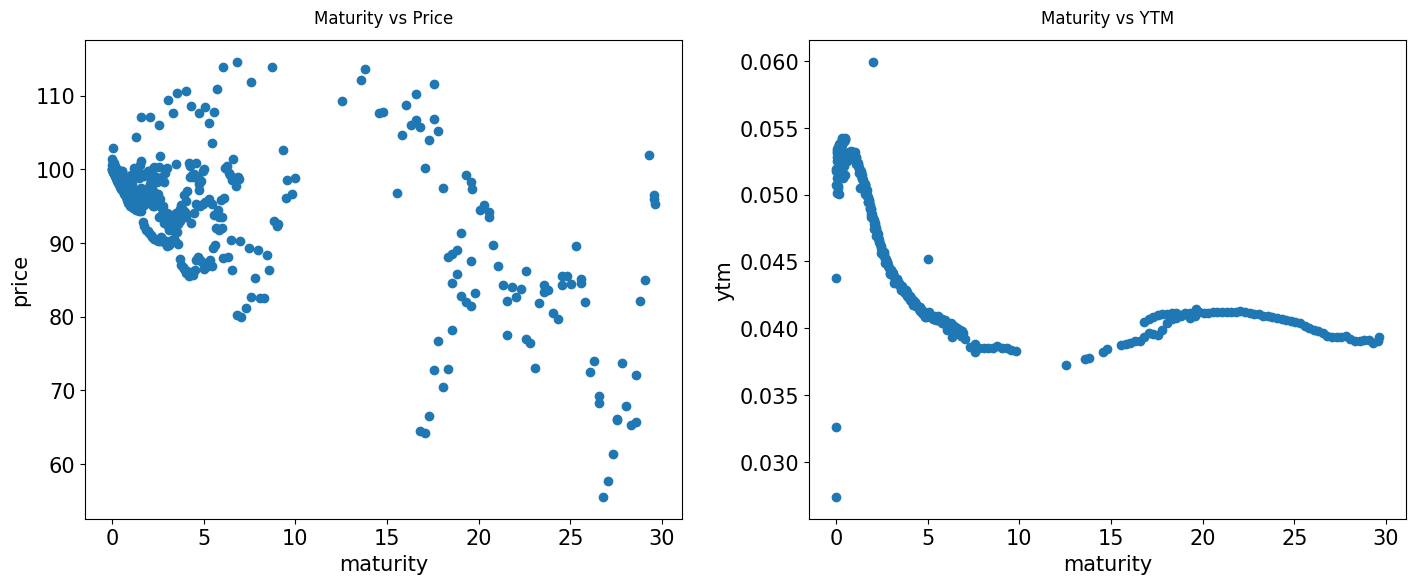

In [8]:
graphs = {'Maturity vs Price': (df['maturity'], df['price']), 'Maturity vs YTM' : (df['maturity'],df['ytm'])}

fig, (ax,ax2) = plt.subplots(ncols=2)
fig.tight_layout(pad=2)

axes = [ax, ax2]

for i, (key,value) in enumerate(graphs.items()):
    axes[i].scatter(value[0], value[1])
    axes[i].set_title(key, fontdict={'fontsize':12}, pad=12)
    axes[i].set_xlabel(value[0].name)
    axes[i].set_ylabel(value[1].name)

fig.set_figwidth(15)
plt.show()

## 5 Bad Data?

Find the issues where `TDYLD` is `NaN`. Display these rows from your table above. How many issues (rows) are effected?

What do you see in the other metrics for these issues that suggests that the price is bad?

In [9]:
display(df[df['yld'].isna()])
print(f"{len(df[df['yld'].isna()])} rows are affected" )

,maturity,price,coupon rate,ytm,yld,bid-ask
KYTREASNO,,,,,,
206701,0.473648,98.386719,0.625,NaN,NaN,0.007812
207348,0.722793,97.580078,0.500,NaN,NaN,0.011719
206759,0.971937,97.017578,0.125,NaN,NaN,0.011719
207431,1.223819,96.402344,0.125,NaN,NaN,0.015625
206816,1.475702,95.802734,0.250,NaN,NaN,0.019531
206468,1.475702,98.767578,2.375,NaN,NaN,0.019531
207528,1.722108,95.175781,0.125,NaN,NaN,0.023438
206878,1.971253,95.664062,0.375,NaN,NaN,0.023438
207623,2.223135,94.998047,0.125,NaN,NaN,0.027344


51 rows are affected


In [10]:
filter_summ = data_summary(filter_data, t_current)
z =len(filter_summ[filter_summ['yld'].isna()])
print(f'{z} entries are NaN when data is filtered (no tips)')

compare_ytm = pd.DataFrame(index = filter_data.index)
for rate in ytm.columns:
    compare_ytm[rate] = filter_data['TDYLD'] * 365.25 - ytm[rate]
compare_ytm['continuous'] = round(compare_ytm['continuous'],6)
compare_ytm.describe()

0 entries are NaN when data is filtered (no tips)


,semiannual,annual,daily,continuous
count,386.000000,386.000000,386.000000,386.000000
mean,-0.000588,-0.001135,-0.000051,-0.000048
std,0.000701,0.000754,0.000672,0.000672
min,-0.013273,-0.014199,-0.012370,-0.012365
25%,-0.000682,-0.001376,-0.000004,-0.000001
50%,-0.000506,-0.001020,-0.000003,0.000000
75%,-0.000422,-0.000849,-0.000002,0.000000
max,-0.000188,-0.000378,-0.000001,0.000000


> - The calculated rates are all relatively close to the provided YTM in the original source. 
> - The continuous rate is the closest to the original YTM. The slight difference may be attributed to the method used in calculating the price based on bid and ask prices.

***

# Problem 2: Extract the Discount Curve

## 1 Map Cashflows

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

You will need to make a few modeling choices to do this...
* eliminate any treasury that does not report `TDYTM` or that reports a negative number for `TDYTM`.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [11]:
display(filter_cf)
CFset = {'all dates, including negative YTM quotes':filter_cf}
most_cf = filter_cf.sum(axis=0)
most_issues = filter_cf[filter_cf >0].count(axis = 0)
print(f'{most_cf.idxmax():%Y-%m-%d} has the most cashflow: {most_cf.max()} across all issues')
print(f'{most_issues.idxmax():%Y-%m-%d} has the most issues: {most_issues.max()} across all dates')

,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2051-09-15,2051-11-15,2052-02-15,2052-03-15,2052-05-15,2052-08-15,2052-09-15,2052-11-15,2053-02-15,2053-03-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207997,100,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
207231,0,101.3750,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
207742,0,100.0625,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
206998,0,100.6250,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
208025,0,0.0000,100,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207891,0,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,1.4375,0.0000,0.0000,101.4375,0.0000,0.0000,0,0.0000,0.0000
207934,0,0.0000,0,0,0,0,1.5000,0,0,0,...,0.0000,0.0000,1.5000,0.0000,0.0000,101.5000,0.0000,0,0.0000,0.0000
207977,0,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,2.0000,0.0000,0.0000,2.0000,0.0000,0.0000,102,0.0000,0.0000


2023-08-15 has the most cashflow: 517.6875 across all issues
2023-08-15 has the most issues: 76 across all dates


## 2 Bootstrap

Bootstrap the discount factors.

Starting with $C$ from the previous problem, further filter to create a subset of Treasury issues cashflow matrix $\tilde{C}$, such that each column has one, and only one, maturity. Also, each issue (row) has its face value payment in one of the columns.

The three step procedure below might be useful.

1. For dates with multiple bonds maturing, keep only that with the smallest bid-ask. If there are still multiple bonds maturing on the date, keep only that with the smallest coupon.

2. Only keep the first $L$ columns of the cashflow matrix, such that every column has a bond maturing on that date.

3. Eliminate any bonds, (rows,) that had maturity beyond column $L$.

This should produce the cashflow matrix, $\tilde{C}$.

**Report 5 head and tail rows of $\tilde{C}$.**

Solve the system of equations
$$\textbf{p} = \tilde{\textbf{C}}\, \textbf{z}_{\text{bootstrap}}$$

**Plot the estimated discount factors, $\textbf{z}$, against time-to-maturity.**

,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2031-02-15,2031-05-15,2031-08-15,2031-11-15,2032-02-15,2032-05-15,2032-08-15,2032-11-15,2033-02-15,2033-05-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207997,100,0.000,0,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
207231,0,101.375,0,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
208025,0,0.000,100,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
207998,0,0.000,0,100,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
208034,0,0.000,0,0,100,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207889,0,0.000,0,0,0,0,0.000,0,0,0,...,0.000,1.4375,0.000,1.4375,0.000,101.4375,0.000,0.0000,0.00,0.0000
207932,0,0.000,0,0,0,0,1.375,0,0,0,...,1.375,0.0000,1.375,0.0000,1.375,0.0000,101.375,0.0000,0.00,0.0000
207975,0,0.000,0,0,0,0,0.000,0,0,0,...,0.000,2.0625,0.000,2.0625,0.000,2.0625,0.000,102.0625,0.00,0.0000


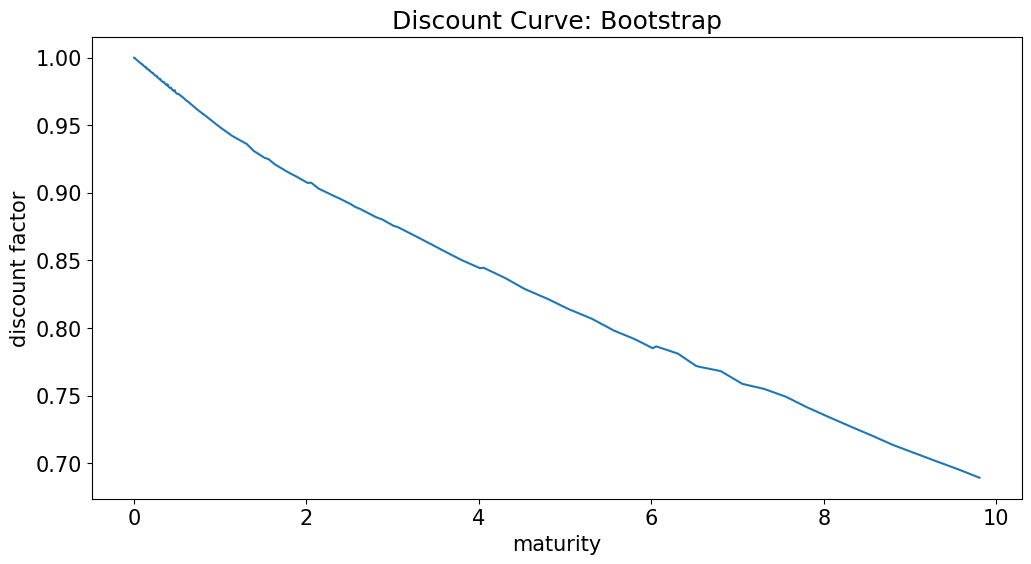

In [12]:
strict_filter_data = filter_treasuries(rdata, t_date=t_current, drop_duplicate_maturities=True, include_tips=False, exclude_zero_yield=True)
strict_filter_cf = filter_treasury_cashflows(calc_cashflow(strict_filter_data), filter_maturity_dates=True)
display(strict_filter_cf)
strict_price = metrics['price'][strict_filter_cf.index]
params_boot = estimate_rate_curve(bootstrap, strict_filter_cf, t_current, strict_price)
CFset['single maturity per date, no non-maturity dates'] = strict_filter_cf
plt.plot(params_boot[0],params_boot[1])
plt.xlabel('maturity')
plt.ylabel('discount factor')
plt.title('Discount Curve: Bootstrap')
plt.show()

## 3. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. (You might do something similar to the three-step procedure of the bootstrap, but skip step #1.) Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

**Plot the discount factors against maturities.**

,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2031-02-15,2031-05-15,2031-08-15,2031-11-15,2032-02-15,2032-05-15,2032-08-15,2032-11-15,2033-02-15,2033-05-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207997,100,0.0000,0,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
207231,0,101.3750,0,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
207742,0,100.0625,0,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
206998,0,100.6250,0,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
208025,0,0.0000,100,0,0,0,0.000,0,0,0,...,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207889,0,0.0000,0,0,0,0,0.000,0,0,0,...,0.000,1.4375,0.000,1.4375,0.000,101.4375,0.000,0.0000,0.00,0.0000
207932,0,0.0000,0,0,0,0,1.375,0,0,0,...,1.375,0.0000,1.375,0.0000,1.375,0.0000,101.375,0.0000,0.00,0.0000
207975,0,0.0000,0,0,0,0,0.000,0,0,0,...,0.000,2.0625,0.000,2.0625,0.000,2.0625,0.000,102.0625,0.00,0.0000


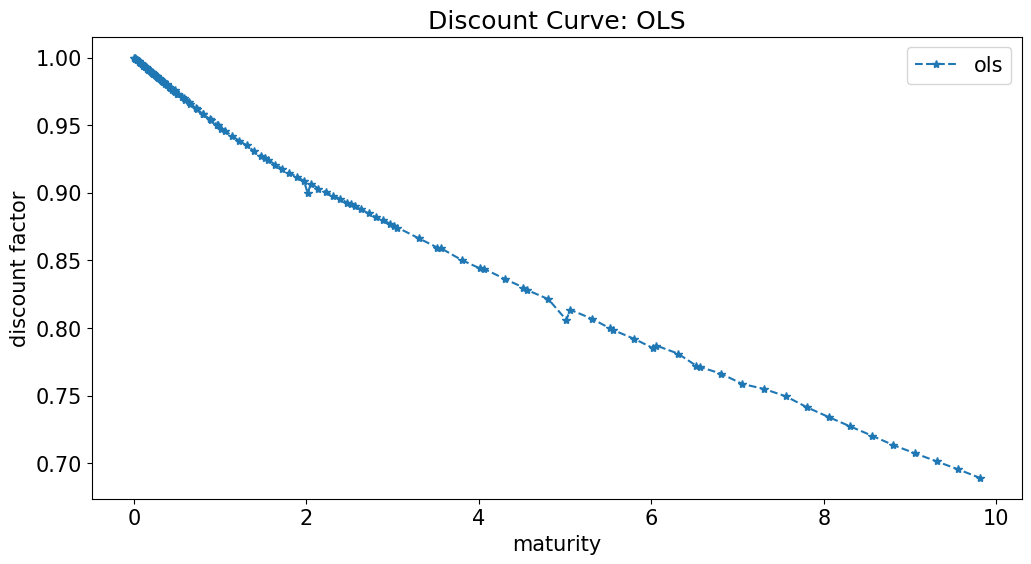

In [13]:
ols_filter_data = filter_treasuries(rdata, t_date=t_current, include_tips=False, exclude_zero_yield=True)
ols_filter_cf = filter_treasury_cashflows(calc_cashflow(ols_filter_data), filter_maturity_dates=True)
display(ols_filter_cf)
ols_price = metrics['price'][ols_filter_cf.index]
params_ols = estimate_rate_curve(bootstrap, ols_filter_cf, t_current, ols_price)
CFset['multiple maturity per date, no non-maturity dates'] = ols_filter_cf
disc_ols = pd.DataFrame({'maturity':params_ols[0], 'ols': params_ols[1]}).set_index('maturity')
disc_ols.plot(marker='*',linestyle='--',ylabel='discount factor',title='Discount Curve: OLS')
plt.show()

## 4 Factors and Rates

Convert $\textbf{z}_{\text{bootstrap}}$ to a set of 
* continuous discount rates
* semiannually compounded discount rates

Do the same for $\textbf{z}_{\text{ols}}$.

Plot the **continuous** discount rates generated via bootstrap and via OLS against time-to-maturity.

Plot the **semiannually compounded** discount rates generated via bootstrap and via OLS against time-to-maturity.

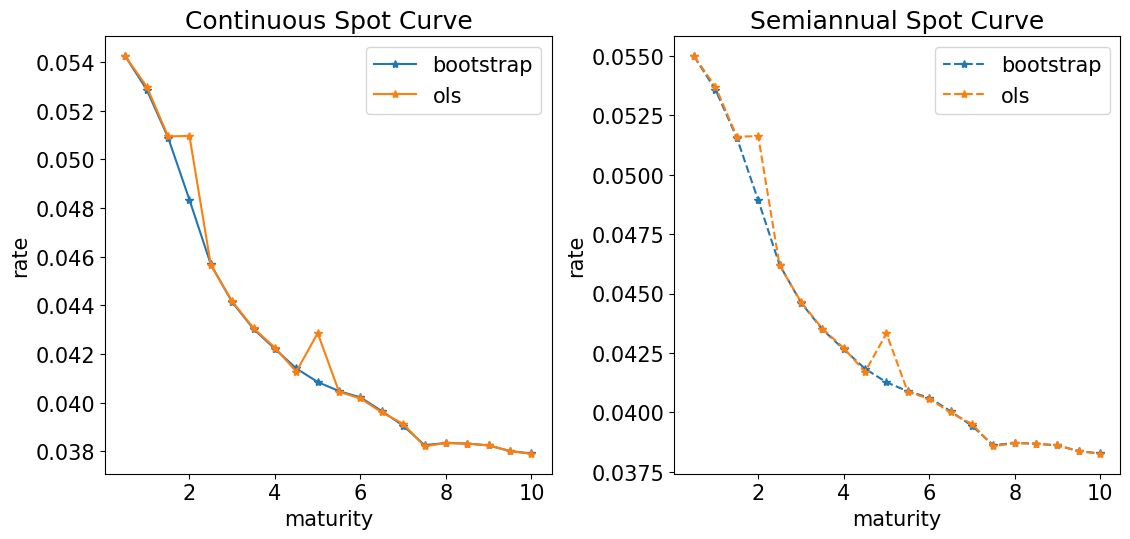

In [14]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=.01)

fig.tight_layout(pad=3)

axes = [ax, ax2]

inc = .5
maturity_grid = np.arange(inc,disc_ols.index.to_series().max()+.5,inc)

curves_ols = pd.DataFrame(index = maturity_grid)
curves_ols['bootstrap'] = bootstrap(params_boot,maturity_grid)
curves_ols['ols'] = bootstrap(params_ols,maturity_grid)

#semiannual compounding
semi = 2
curves_ols_semi = pd.DataFrame(index = maturity_grid)
curves_ols_semi['bootstrap'] = semi_bootstrap(params_boot,maturity_grid, semi)
curves_ols_semi['ols'] = semi_bootstrap(params_ols,maturity_grid, semi)

curves_ols.plot(linestyle='-',marker='*',ylabel='rate',xlabel='maturity', ax= ax, title='Continuous Spot Curve')
curves_ols_semi.plot(linestyle='--',marker='*',ylabel='rate',xlabel='maturity', ax = ax2, title='Semiannual Spot Curve')
plt.show()

***

# Problem 3: Nelson-Siegel Curve

Use the Nelson-Siegel curve to model the discount rates. 

Fit them via minimizing the sum of squared errors for the prices imputed by the model versus the quoted prices. 

Consider using `minimize` from `scipy.optimize`.

* Estimate the model three times, using $\textbf{C}$, $\tilde{\textbf{C}}$, $\hat{\textbf{C}}$.

* Plot the estimated discount factors, $\textbf{z}_{\text{ns}}$ against time-to-maturity.

* Also plot the associated continuously-compounded discount rates.

# $\textbf{C}$

,theta 0,theta 1,theta 2,lambda_1,theta_3,lambda_2
Nelson-Siegel,0.041537,0.020725,-0.032744,2.437959,None,None
Nelson-Siegel Extended,0.041354,0.035303,-0.043113,2.078893,-0.06557,0.135823


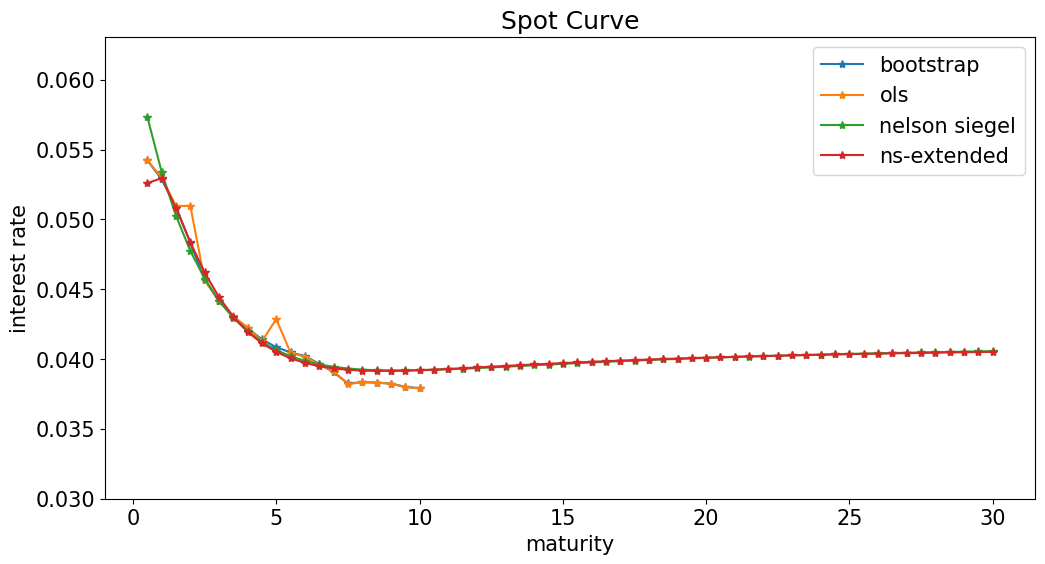

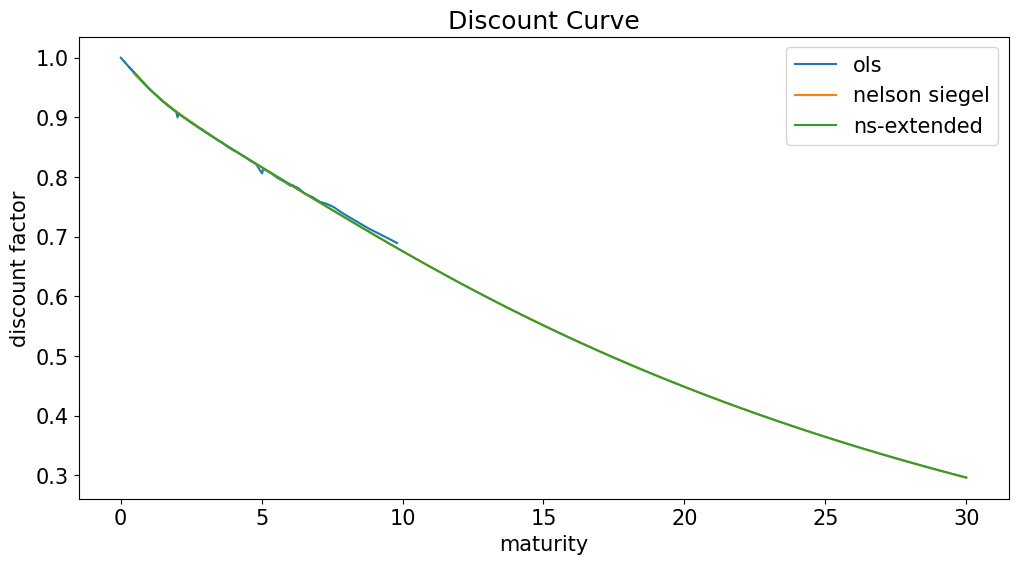

In [15]:
keys = list(CFset.keys())
CF = CFset[keys[0]]
prices = metrics['price'][CF.index]

x0 = np.ones(4)/10
params_NS = estimate_rate_curve(nelson_siegel,CF,t_current,prices,x0)

x0 = np.concatenate((params_NS,(1/10,1/10)))
params_NSE = estimate_rate_curve(nelson_siegel_extended,CF,t_current,prices,x0=x0)

tab_params_ns = pd.DataFrame(data = params_NS, index=['theta 0', 'theta 1', 'theta 2', 'lambda_1'],columns=['Nelson-Siegel']).T
tab_params_ns.loc[:,['theta_3', 'lambda_2']] = None
tab_params_ns.loc['Nelson-Siegel Extended',:] = params_NSE
display(tab_params_ns)

inc = .5

maturity_list = get_maturity_delta(list(CFset.values())[0].columns,t_current=t_current)
maturity_grid = np.arange(inc,maturity_list.max()+.5,inc)
curves = pd.DataFrame(index = maturity_grid)
curves['nelson siegel'] = nelson_siegel(params_NS,maturity_grid)
curves['ns-extended']= nelson_siegel_extended(params_NSE,maturity_grid)

ax = curves_ols.plot(linestyle='-',marker='*')
curves.plot(ax=ax, linestyle='-',marker='*', ylim=(.03,curves.max().max()*1.1))

series_plotted = list(curves_ols.columns) + list(curves.columns)
plt.legend(series_plotted)
plt.xlabel('maturity')
plt.ylabel('interest rate')
plt.title('Spot Curve')
plt.show()

params_ols = estimate_rate_curve(bootstrap,CF,t_current,prices)

ax = disc_ols.plot()

zero_curve = intrate_to_discount(curves.loc[:,'nelson siegel'], maturity_grid, n_compound=None).to_frame()
zero_curve['ns-extended'] = intrate_to_discount(curves.loc[:,'ns-extended'], maturity_grid, n_compound=None).to_frame()
zero_curve.plot(ax=ax, title='Discount Curve', xlabel='maturity',ylabel='discount factor')

plt.show()

# $\tilde{\textbf{C}}$

,theta 0,theta 1,theta 2,lambda_1,theta_3,lambda_2
Nelson-Siegel,0.019373,0.097992,0.098043,0.096198,None,None
Nelson-Siegel Extended,0.039105,0.073259,0.077281,0.063018,0.07884,0.088212


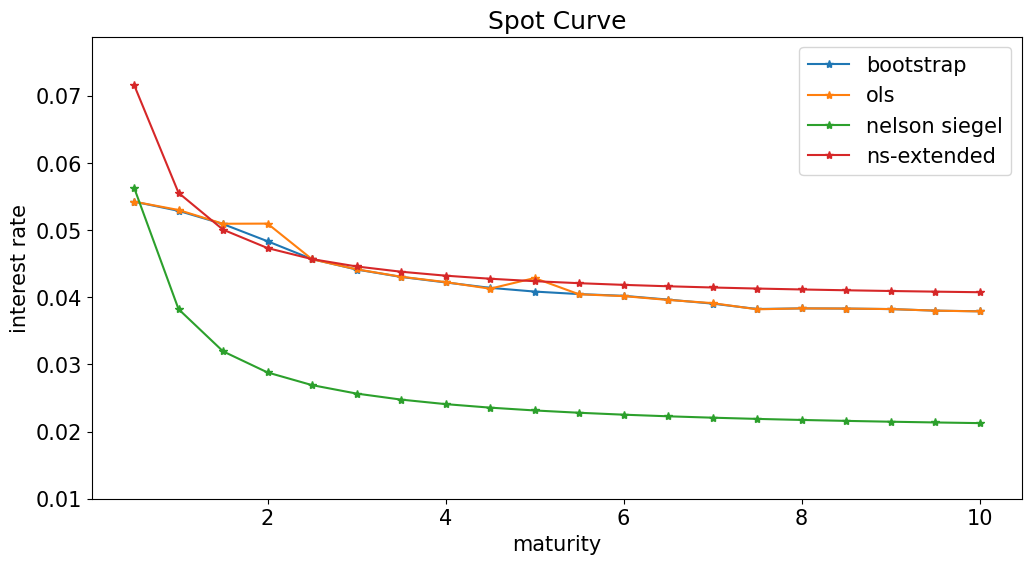

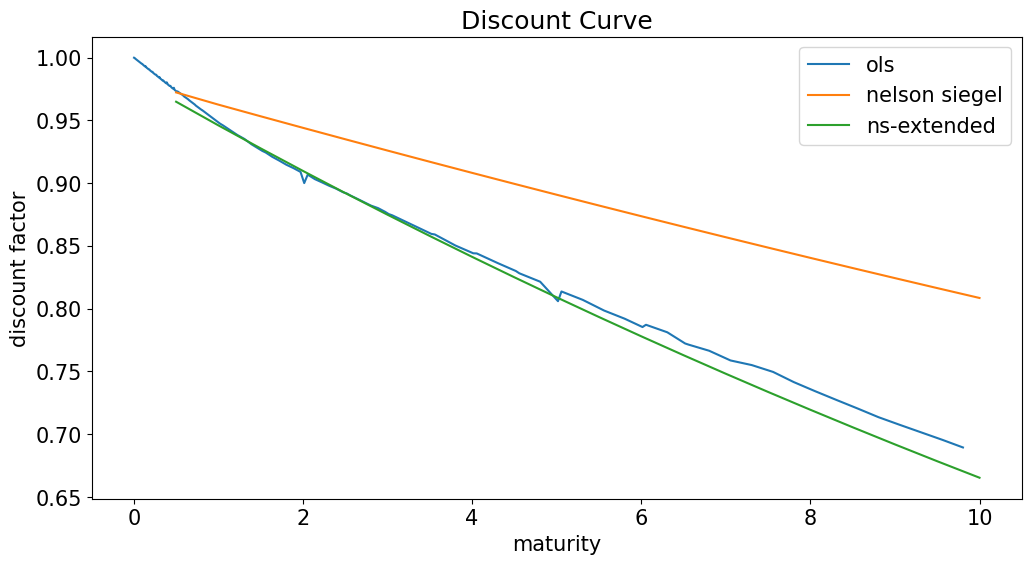

In [16]:
keys = list(CFset.keys())
CF = CFset[keys[1]]
prices = metrics['price'][CF.index]

x0 = np.ones(4)/10
params_NS = estimate_rate_curve(nelson_siegel,CF,t_current,prices,x0)

x0 = np.concatenate((params_NS,(1/10,1/10)))
params_NSE = estimate_rate_curve(nelson_siegel_extended,CF,t_current,prices,x0=x0)

tab_params_ns = pd.DataFrame(data = params_NS, index=['theta 0', 'theta 1', 'theta 2', 'lambda_1'],columns=['Nelson-Siegel']).T
tab_params_ns.loc[:,['theta_3', 'lambda_2']] = None
tab_params_ns.loc['Nelson-Siegel Extended',:] = params_NSE
display(tab_params_ns)

inc = .5

maturity_list = get_maturity_delta(list(CFset.values())[1].columns,t_current=t_current)
maturity_grid = np.arange(inc,maturity_list.max()+.5,inc)
curves = pd.DataFrame(index = maturity_grid)
curves['nelson siegel'] = nelson_siegel(params_NS,maturity_grid)
curves['ns-extended']= nelson_siegel_extended(params_NSE,maturity_grid)

ax = curves_ols.plot(linestyle='-',marker='*')
curves.plot(ax=ax, linestyle='-',marker='*', ylim=(.01,curves.max().max()*1.1))

series_plotted = list(curves_ols.columns) + list(curves.columns)
plt.legend(series_plotted)
plt.xlabel('maturity')
plt.ylabel('interest rate')
plt.title('Spot Curve')
plt.show()

params_ols = estimate_rate_curve(bootstrap,CF,t_current,prices)

ax = disc_ols.plot()

zero_curve = intrate_to_discount(curves.loc[:,'nelson siegel'], maturity_grid, n_compound=None).to_frame()
zero_curve['ns-extended'] = intrate_to_discount(curves.loc[:,'ns-extended'], maturity_grid, n_compound=None).to_frame()
zero_curve.plot(ax=ax, title='Discount Curve', xlabel='maturity',ylabel='discount factor')

plt.show()

# $\hat{\textbf{C}}$

,theta 0,theta 1,theta 2,lambda_1,theta_3,lambda_2
Nelson-Siegel,0.020064,0.097790,0.097840,0.095789,None,None
Nelson-Siegel Extended,0.038509,0.074121,0.077802,0.063241,0.079502,0.088176


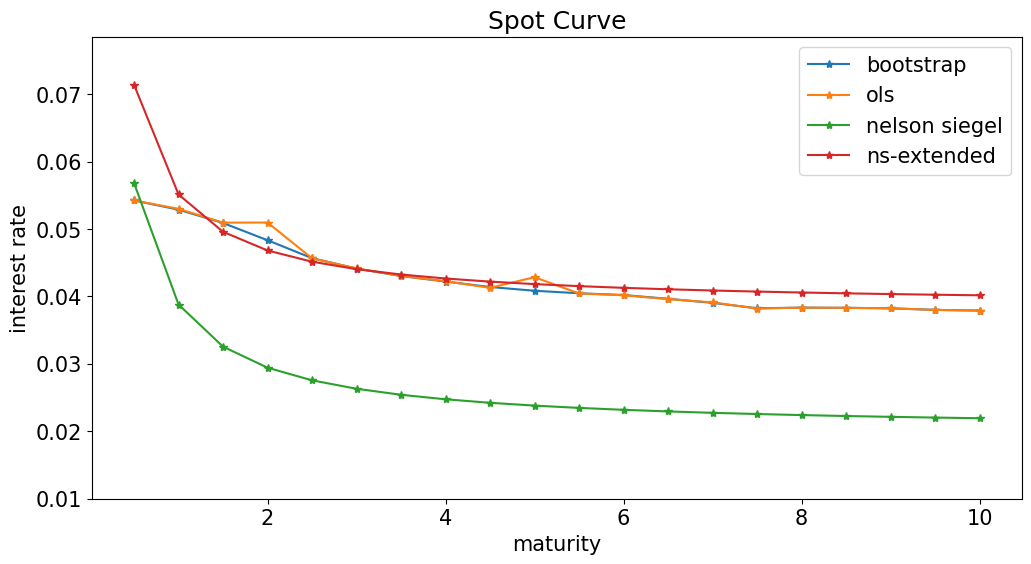

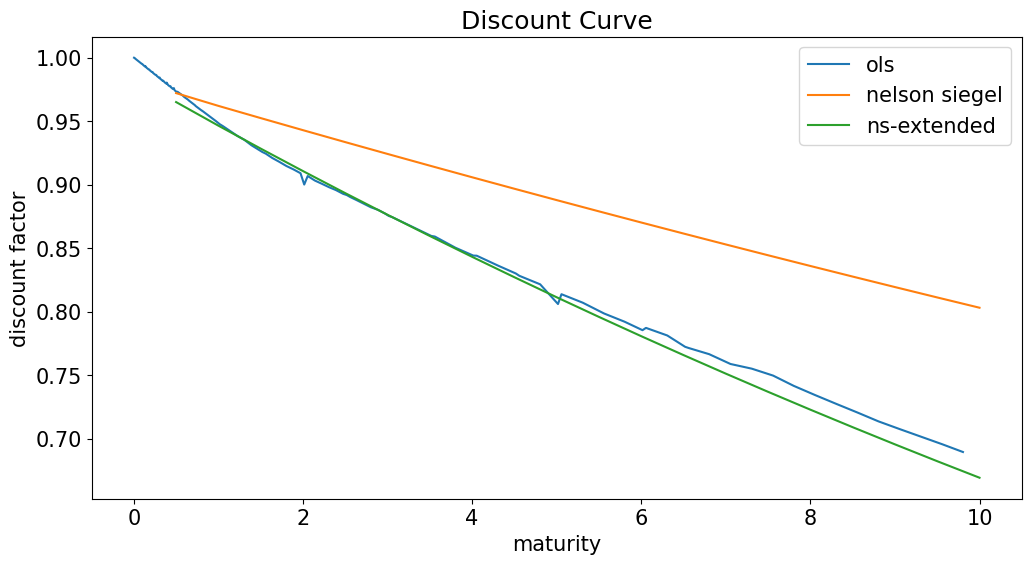

In [17]:
keys = list(CFset.keys())
CF = CFset[keys[-1]]
prices = metrics['price'][CF.index]

x0 = np.ones(4)/10
params_NS = estimate_rate_curve(nelson_siegel,CF,t_current,prices,x0)

x0 = np.concatenate((params_NS,(1/10,1/10)))
params_NSE = estimate_rate_curve(nelson_siegel_extended,CF,t_current,prices,x0=x0)

tab_params_ns = pd.DataFrame(data = params_NS, index=['theta 0', 'theta 1', 'theta 2', 'lambda_1'],columns=['Nelson-Siegel']).T
tab_params_ns.loc[:,['theta_3', 'lambda_2']] = None
tab_params_ns.loc['Nelson-Siegel Extended',:] = params_NSE
display(tab_params_ns)

inc = .5

maturity_list = get_maturity_delta(list(CFset.values())[-1].columns,t_current=t_current)
maturity_grid = np.arange(inc,maturity_list.max()+.5,inc)
curves = pd.DataFrame(index = maturity_grid)
curves['nelson siegel'] = nelson_siegel(params_NS,maturity_grid)
curves['ns-extended']= nelson_siegel_extended(params_NSE,maturity_grid)

ax = curves_ols.plot(linestyle='-',marker='*')
curves.plot(ax=ax, linestyle='-',marker='*', ylim=(.01,curves.max().max()*1.1))

series_plotted = list(curves_ols.columns) + list(curves.columns)
plt.legend(series_plotted)
plt.xlabel('maturity')
plt.ylabel('interest rate')
plt.title('Spot Curve')
plt.show()

params_ols = estimate_rate_curve(bootstrap,CF,t_current,prices)

ax = disc_ols.plot()

zero_curve = intrate_to_discount(curves.loc[:,'nelson siegel'], maturity_grid, n_compound=None).to_frame()
zero_curve['ns-extended'] = intrate_to_discount(curves.loc[:,'ns-extended'], maturity_grid, n_compound=None).to_frame()
zero_curve.plot(ax=ax, title='Discount Curve', xlabel='maturity',ylabel='discount factor')

plt.show()